# Training curve of the GBT model

In this final notebook, we analyze the impact of the training set size on the training and test set performance of our best algorithm implemented on Spark (a gradient boosted tree with tuned hyperparameters).

In [1]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
inputPath = "/user/s291516/preprocessed/"
trainData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "trainData/").cache()
testData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "testData/").cache()

## Evaluators definition

In [3]:
rmseEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="rmse")
r2Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="r2")
resultsDF = pd.DataFrame(columns=["Fraction", "Metric", "Train", "Test"])

## Label mapper definition

In [4]:
class LabelMapper(Transformer):
    def _transform(self, inputDF):
        return inputDF.withColumn("prediction", F.col("prediction") + F.col("NumBikes"))

## Pipeline definition

In [5]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42, maxIter=50, stepSize=0.25),
    LabelMapper()
])

## Sampling

In [6]:
numFolds = 10
trainData = trainData.withColumn("Fold", F.floor(F.rand(seed=42) * numFolds))
trainData.groupBy("Fold").count().orderBy("Fold").show()

+----+------+
|Fold| count|
+----+------+
|   0|230792|
|   1|229718|
|   2|229880|
|   3|230765|
|   4|229868|
|   5|229098|
|   6|230369|
|   7|230405|
|   8|229676|
|   9|229785|
+----+------+



## Performance measurements

In [7]:
for i in range(numFolds):
    # Create the train sample by selecting the first i folds
    trainSample = trainData.filter(F.col("Fold") <= i)
    
    # Fit the pipeline on the train sample
    model = pipeline.fit(trainSample)
    
    # Evaluate on the training and test sets
    trainRMSE = rmseEvaluator.evaluate(model.transform(trainSample))
    trainR2 = r2Evaluator.evaluate(model.transform(trainSample))
    testRMSE = rmseEvaluator.evaluate(model.transform(testData))
    testR2 = r2Evaluator.evaluate(model.transform(testData))
    resultsDF = resultsDF.append([
        {"Fraction": (i + 1) / numFolds, "Metric": "RMSE", "Train": trainRMSE, "Test": testRMSE},
        {"Fraction": (i + 1) / numFolds, "Metric": "R2", "Train": trainR2, "Test": testR2}
    ], ignore_index=True)
    
    print(f"Completed iteration #{i + 1} (RMSE train: {trainRMSE}, R2 train: {trainR2}, RMSE test: {testRMSE}, R2 test: {testR2}).")

Completed iteration #1 (RMSE train: 1.4194738707966563, R2 train: 0.9622605284229473, RMSE test: 1.417468521952422, R2 test: 0.967523781168749).
Completed iteration #2 (RMSE train: 1.4269255019217502, R2 train: 0.9619257114089291, RMSE test: 1.4141573962146208, R2 test: 0.9676753291531671).
Completed iteration #3 (RMSE train: 1.43113665728232, R2 train: 0.961665334683697, RMSE test: 1.41252407821595, R2 test: 0.9677499544777707).
Completed iteration #4 (RMSE train: 1.430542682589848, R2 train: 0.9616776605274858, RMSE test: 1.4123073662734495, R2 test: 0.9677598494367148).
Completed iteration #5 (RMSE train: 1.433626523443784, R2 train: 0.9615261711187771, RMSE test: 1.4114516335686191, R2 test: 0.9677989069303999).
Completed iteration #6 (RMSE train: 1.4348222145106344, R2 train: 0.9614779601539117, RMSE test: 1.4114634577589271, R2 test: 0.967798367410039).
Completed iteration #7 (RMSE train: 1.4351724301290991, R2 train: 0.961462081321043, RMSE test: 1.4109308036990456, R2 test: 0.9

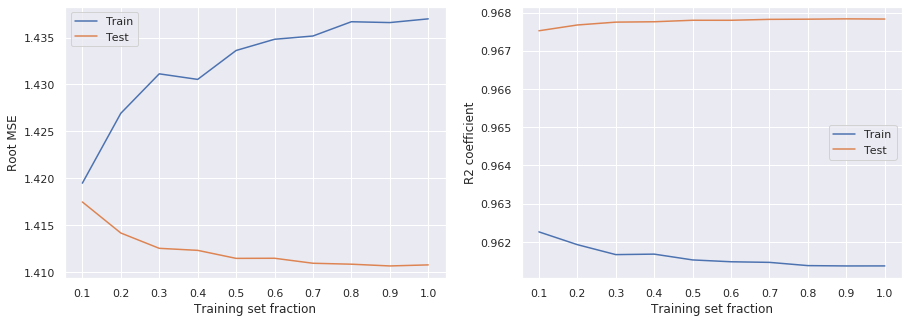

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
resultsDF[resultsDF["Metric"] == "RMSE"].plot(x="Fraction", y=["Train", "Test"], ax=ax[0])
resultsDF[resultsDF["Metric"] == "R2"].plot(x="Fraction", y=["Train", "Test"], ax=ax[1])
ax[0].set_xticks([(i + 1) / numFolds for i in range(numFolds)])
ax[1].set_xticks([(i + 1) / numFolds for i in range(numFolds)])
ax[0].set_xlabel("Training set fraction")
ax[1].set_xlabel("Training set fraction")
ax[0].set_ylabel("Root MSE")
ax[1].set_ylabel("R2 coefficient");